In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as getcwd
import string
import re

In [2]:
def process_tweet(tweet):
    """
    Parameters:
    -----------
        tweet: string
        
    Returns:
    --------
        tweet_stem: list of stemmed words in tweet
    """
    tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    stopwords_english=stopwords.words('english')
    stemmer=PorterStemmer()
    
    tweet=re.sub(r'https?://[^\s\n\r]+','',tweet)
    tweet=re.sub(r'#','',tweet)
    tweet_tokenized=tokenizer.tokenize(tweet)
    
    tweet_clean=[]
    for word in tweet_tokenized:
        if word not in stopwords_english and word not in string.punctuation:
            tweet_clean.append(word)
    
    tweet_stem=[]
    for word in tweet_clean:
        stem_word=stemmer.stem(word)
        tweet_stem.append(stem_word)
    
    return tweet_stem

In [3]:
def build_freqs(tweets,ys):
    """
    Parameters:
    -----------
        tweets: list of tweets
    
        ys: m x 1 array with the sentiment label (1 or 0)
    
    Returns:
    --------
        freqs: dict mapping each (word,sentiment) pair to its frequency
    """
    yslist=np.squeeze(ys).tolist()
    freqs={}
    for y,tweet in zip(yslist,tweets):
        for word in process_tweet(tweet):
            pair=(word,y)
            if pair in freqs:
                freqs[pair]+=1
            else:
                freqs[pair]=1
    return freqs

In [5]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\pk764\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pk764\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
positive_tweets=twitter_samples.strings('positive_tweets.json')
negative_tweets=twitter_samples.strings('negative_tweets.json')
print('positive: ',len(positive_tweets))
print('negative: ',len(negative_tweets))
tweets=positive_tweets+negative_tweets
train_pos=positive_tweets[:4000]
train_neg=negative_tweets[:4000]
train_x=train_pos+train_neg

positive:  5000
negative:  5000


In [5]:
labels=np.append(np.ones(len(positive_tweets)),np.zeros(len(negative_tweets)))

#### loading dataset 

In [6]:
data=pd.read_csv('data/logistic_features.csv')
data.head()

,bias,positive,negative,sentiment
0,1.0,3020.0,61.0,1.0
1,1.0,3573.0,444.0,1.0
2,1.0,3005.0,115.0,1.0
3,1.0,2862.0,4.0,1.0
4,1.0,3119.0,225.0,1.0


In [7]:
X=data[['bias','positive','negative']].values
Y=data[['sentiment']].values

#### loading pretrained Logistic Regressoin model

In [9]:
theta=[6.0351887e-08,5.38184972e-04,-5.58300168e-04]

#### plot samples

Text(0, 0.5, 'negative')

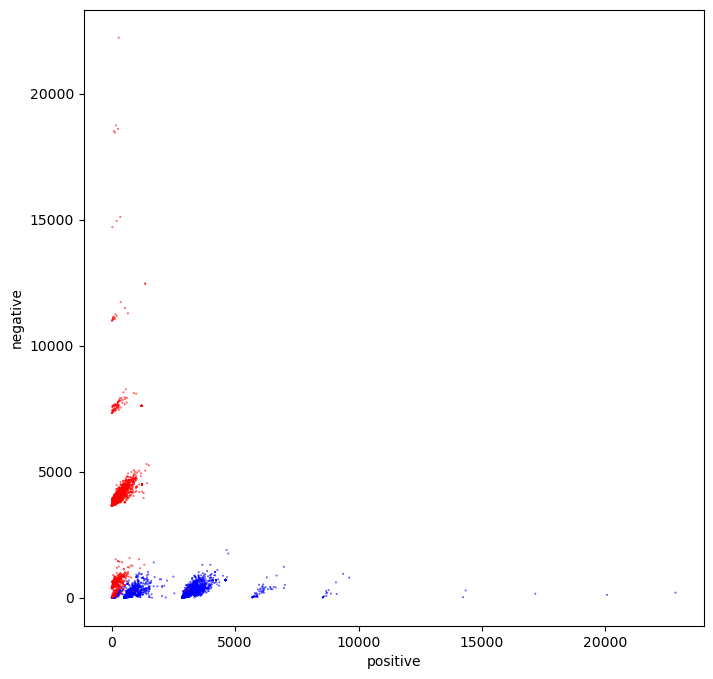

In [35]:
plt.figure(figsize=(8,8))
colors=['red','blue']
plt.scatter(X[:,1],X[:,2],color=[colors[int(k)] for k in Y],s=0.1)
plt.xlabel('positive')
plt.ylabel('negative')

#### plotting model

$$ z=\theta*x=0 $$

$$ x=[1,pos,neg] $$

$$ z(\theta)=\theta_0+\theta_1*pos+\theta_2*neg = 0 $$

$$ neg=-\frac{\theta_0+\theta_1*pos}{\theta_2} $$

$$ direction=\frac{pos*\theta_2}{\theta_1} $$

In [10]:
def neg(theta,pos):
    return -(theta[0]+theta[1]*pos)/theta[2]

def direction(theta,pos):
    return pos*theta[2]/theta[1]

Text(0, 0.5, 'negative')

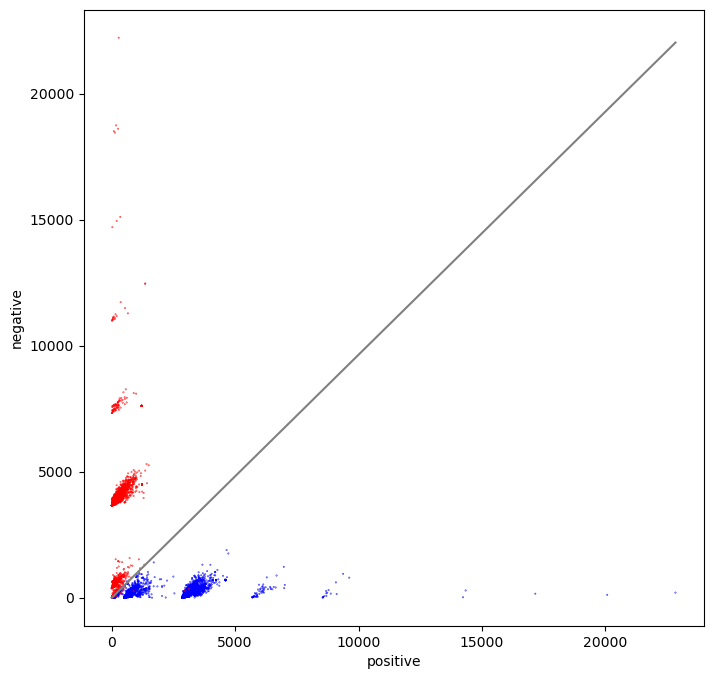

In [11]:
plt.figure(figsize=(8,8))
colors=['red','blue']
plt.scatter(X[:,1],X[:,2],color=[colors[int(k)] for k in Y],s=0.1)

maxpos=np.max(X[:,1])
plt.plot([0,maxpos],[neg(theta,0),neg(theta,maxpos)],color='gray')

plt.xlabel('positive')
plt.ylabel('negative')

## Training LR

#### How to convert raw text to numerical features for NLP 
Count the times that each word from the tweets (Vocabulary) appear in each of the categories (positive and negative), then sum up those counts for each of your tweets in each category. You’ll end up with a feature vector with n features, where n is the number of categories.


Then sum up the positive and negative frequencies of words in each tweett, getting the feature for the whole tweett.

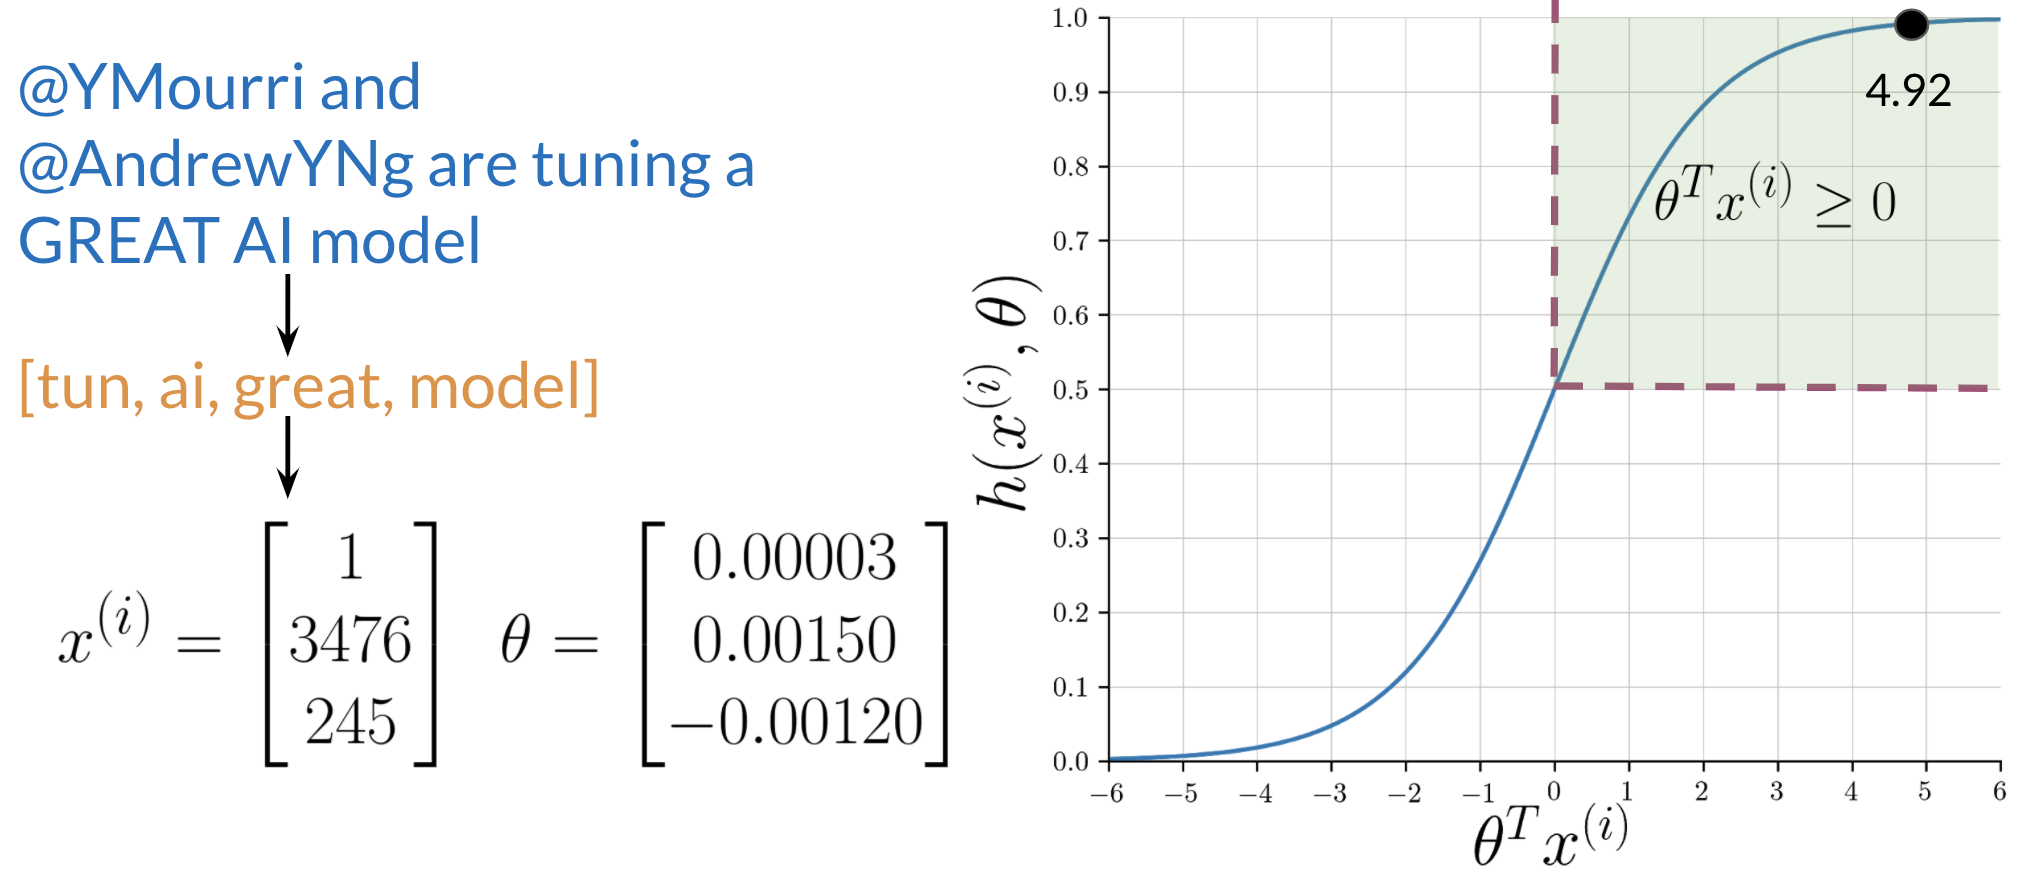

In [13]:
positive_tweets=twitter_samples.strings('positive_tweets.json')
negative_tweets=twitter_samples.strings('negative_tweets.json')
tweets=positive_tweets+negative_tweets
train_pos=positive_tweets[:4000]
train_neg=negative_tweets[:4000]
test_pos=positive_tweets[4000:]
test_neg=negative_tweets[4000:]
train_x=train_pos+train_neg
test_x=test_pos+test_neg

In [14]:
train_y=np.append(np.ones((len(train_pos),1)),np.zeros((len(train_neg),1)),axis=0)
test_y=np.append(np.ones((len(test_pos),1)),np.zeros((len(test_neg),1)),axis=0)

In [15]:
freqs=build_freqs(train_x,train_y)

In [16]:
train_x[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

In [17]:
process_tweet(train_x[0])

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']

#### sigmoid

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

$$ z=\theta_0 x_0+\theta_1 x_1+\theta_2 x_2 $$

In [18]:
def sigmoid(z):
    '''
    Parameters:
    -----------
        z: scalar or array
    
    Returns:
    --------
        h: sigmoid of z
    '''
    h=1/(1+np.exp(-z))
    return h

#### cost function

$$ J(\theta) = -\frac{1}{m} \sum_{i=1}^m [y^{(i)}\log(h(z^{(i)}) + (1-y^{(i)})\log(1-h(z^{(i)})] $$

Vectorised:

$$ J = -\frac{1}{m} \times [y^T \cdot \log(h) + (1-y)^T \cdot \log(1-h)] $$

Gradient of cost

$$ dJ_j=\frac{1}{m} \sum_{i=0}^{m-1} (h(x^{(i)})-y^{(i)})*x^{(i)}_j $$

$$ \frac{\partial J}{\partial \theta} = \frac{1}{m} \times [x \cdot (h-y)] $$

Vectorised update of $ \theta $

$$ \theta = \theta -\frac{\alpha}{m} \times [x \cdot (h-y)] $$

#### gradient descent

In [19]:
def gradient_descent(x,y,theta,alpha,num_iters):
    '''
    Parameters:
    -----------
        x: matrix of features (m,n+1)
        y: corresponding labels of input matrix (m,1)
        theta: weight vector (n+1,1)
        alpha: learning rate
        num_ters: number of iterations
    
    Returns:
    --------
        J: cost 
        theta: weight vector
    '''
    m=len(x)
    for i in range(0,num_iters):
        z=np.dot(x,theta)
        h=sigmoid(z)
        J=(y*np.log(h)+(1-y)*np.log(1-h))
        J=-np.sum(J)/m
        d_theta=((x*(h-y)).sum(axis=0)).reshape((-1, 1))
        theta=theta-alpha/m*d_theta
        if i%100==0:
            print(f'LOSS: {J}')
    return J,theta

In [20]:
np.random.seed(1)
x=np.append(np.ones((10,1)),np.random.rand(10,2)*2000,axis=1)
y=(np.random.rand(10,1)>0.35).astype(float)
theta=np.zeros((3,1))

In [21]:
gradient_descent(x,y,theta,1e-8,700)

LOSS: 0.6931471805599453
LOSS: 0.6860007330930001
LOSS: 0.6816356722595802
LOSS: 0.6786294128534059
LOSS: 0.6763047529059103
LOSS: 0.6743379341372704
LOSS: 0.6725729492240073


(0.6709497038162116,
 array([[4.10713435e-07],
        [3.56584699e-04],
        [7.30888526e-05]]))

#### build frequencies

A dict describing how many times a certain word appears in positive and negative context

In [21]:
def build_freqs(tweets,ys):
    """
    Parameters:
    -----------
        tweets: list of tweets
    
        ys: m x 1 array with the sentiment label (1 or 0)
    
    Returns:
    --------
        freqs: dict mapping each (word, sentiment) pair (word, 0) and (word, 1) to its frequency for each sentiment
            (in other words, negative and positive frequencies)
    """
    yslist=np.squeeze(ys).tolist()
    freqs={}
    for y,tweet in zip(yslist,tweets):
        for word in process_tweet(tweet):
            pair=(word,y)
            if pair in freqs:
                freqs[pair]+=1
            else:
                freqs[pair]=1
    return freqs

In [22]:
freqs=build_freqs(train_x,train_y)
print('len(freqs): ',len(freqs))

len(freqs):  11396


In [34]:
word = 'top'
result = [item for item in freqs if word in item]
print(result)

[('top', 1.0), ('top', 0.0)]


#### extracting features

In [24]:
def extract_features(tweet,freqs):
    '''
    Parameters:
    -----------
        tweet: string tweet
        freqs: dict of word frequencies for each tuple (word,label)
    
    Returns:
    --------
        x: feature vector (1,3) like [0,pos,neg] where 0 is bias, pos is summed pos freaq for words in tweet, 
        neg is summed neg freaq for words in tweet.
    '''
    tweet=process_tweet(tweet)
    x=np.zeros(3)
    for word in tweet:
        x[1]+=freqs.get((word,1),0)
        x[2]+=freqs.get((word,0),0)
    return x

Example:

In [25]:
tmp1=extract_features(train_x[0],freqs)
tmp1

array([   0., 3133.,   61.])

#### training the model

In [26]:
X=np.zeros((len(train_x),3))
for i in range(len(train_x)):
    X[i,:]=extract_features(train_x[i],freqs)
Y=train_y
theta=np.zeros((3,1))

In [27]:
J,theta=gradient_descent(X,Y,theta,1e-9,1500)
print(f'Final cost: {J}')
print(f'Theta weigts: {theta}')

LOSS: 0.6931471805599454
LOSS: 0.5952230002349533
LOSS: 0.5218607977390498
LOSS: 0.46540371635665057
LOSS: 0.4208770027300046
LOSS: 0.3850158788570843
LOSS: 0.3556128904834394
LOSS: 0.33113142020533465
LOSS: 0.3104737262324057
LOSS: 0.2928375288789805
LOSS: 0.2776246352037948
LOSS: 0.26438107414095496
LOSS: 0.25275687543015757
LOSS: 0.24247842957505233
LOSS: 0.23332910580468696
Final cost: 0.22521310307366896
Theta weigts: [[ 0.       ]
 [ 0.0005382]
 [-0.0005583]]


#### testing the model

In [28]:
def predict_tweet(tweet,freqs,theta):
    '''
    Parameters:
    -----------
        tweet: string tweet
        freqs: dict of word frequencies for each tuple (word,label)
        theta: vector of weights (3,1)
        
    Returns:
    --------
        y_pred: probability of a tweet being positive/negative
    '''
    x=extract_features(tweet,freqs)
    z=np.dot(x,theta)
    y_pred=sigmoid(z)
    
    return y_pred

In [29]:
for tweet in ['I am happy','I am bad','great','I hate you']:
    print(f'{tweet} -> {predict_tweet(tweet,freqs,theta)}')

I am happy -> [0.51927503]
I am bad -> [0.49434685]
great -> [0.51606495]
I hate you -> [0.49493022]


In [32]:
def test_model(test_x,test_y,freqs,theta):
    '''
    Parameters:
    -----------
        x: list of tweets
        y: list of tweet labels
        freqs: dict of word frequencies for each tuple (word,label)
        theta: vector of weights (3,1)
        
    Returns:
    --------
        accuracy: accuracy of the model
    '''
    m=len(test_x)
    predictions=[]
    for i in range(m):
        prediction=predict_tweet(test_x[i],freqs,theta)
        if prediction>0.5:
            predictions.append([1.0])
        else:
            predictions.append([0.0])
    accuracy = (predictions == test_y).mean()
    
    return accuracy,predictions

In [33]:
acc,pred=test_model(test_x,test_y,freqs,theta)

In [34]:
acc

0.9955

#### analysis

In [35]:
for x,y in zip(test_x,test_y):
    y_hat=predict_tweet(x,freqs,theta)
    if np.abs(y-(y_hat>0.5))>0:
        print(f'TWEET: {x}')
        print(f'PROCESSED TWEET: {process_tweet(x)}')
        print(f'{y} {y_hat}')
        print('------------')

TWEET: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
PROCESSED TWEET: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
[1.] [0.48915103]
------------
TWEET: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
PROCESSED TWEET: ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] [0.4841899]
------------
TWEET: I'm playing Brain Dots : ) #BrainDots http://t.co/aOKldo3GMj http://t.co/xWCM9qyRG5
PROCESSED TWEET: ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] [0.4841899]
------------
TWEET: I'm playing Brain Dots : ) #BrainDots http://t.co/R2JBO8iNww http://t.co/ow5BBwdEMY
PROCESSED TWEET: ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] [0.4841899]
------------
TWEET: off to the park to get some sunlight : )
PROCESSED TWEET: ['park', 'get', 'sunlight']
[1.] [0.49636411]
------------
TWEE